# Download the Data

In [1]:
!pip3 install tqdm
!pip3 install pillow --upgrade

^C
ERROR: Operation cancelled by user
     |████████████████████████████████| 2.2 MB 12.8 MB/s eta 0:00:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [3]:
%matplotlib inline

import os
import io
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


# Visualize Data

In [4]:
trimaps_dir = 'data/annotations/trimaps/'

maps = [x for x in os.listdir(trimaps_dir) if x[-3:] == 'png']
print(len(maps))

14780


In [5]:
image_dir = 'data/images/'

images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

7390


In [6]:
images[0]

'leonberger_183.jpg'

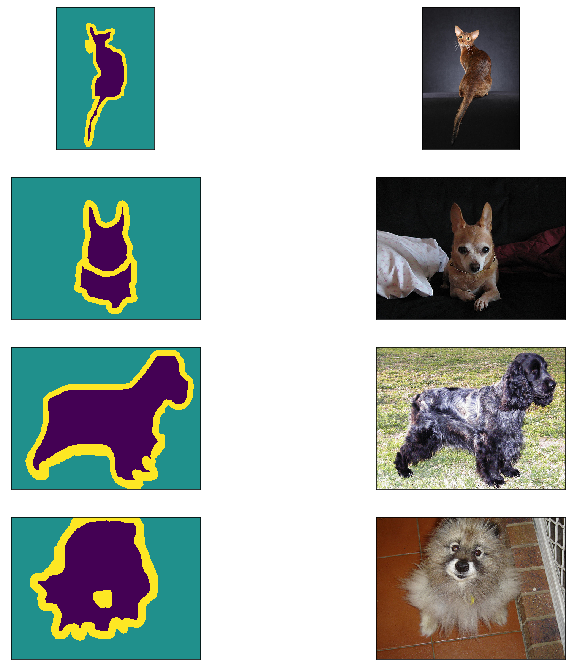

In [7]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_name = images[index]
    map_name = images[index].split('.')[0] + '.png'

    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(trimaps_dir, map_name)))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(image_dir, image_name)))
plt.show()

In [8]:
img = Image.open(os.path.join(trimaps_dir, maps[0]))
print(np.unique(img))

[1 2 3]


# SageMaker Setup

In [9]:
role = sagemaker.get_execution_role()
bucket_name = 'petsdatafajim1234'
training_image = get_image_uri(boto3.Session().region_name,'semantic-segmentation',
                              repo_version='latest')
print(training_image)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


811284229777.dkr.ecr.us-east-1.amazonaws.com/semantic-segmentation:latest


In [10]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [14]:
def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file
    
for image in tqdm(images):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    
    image_file_path = os.path.join('data/images/', image)
    image_target_path = os.path.join(target_set, image)
    
    map_file_path = os.path.join(trimaps_dir, get_map_file(image))
    map_target_path = os.path.join(target_set + '_annotation', get_map_file(image))
    
    shutil.copy(image_file_path, image_target_path)
    shutil.copy(map_file_path, map_target_path)


100%|██████████| 7390/7390 [02:58<00:00, 41.38it/s] 


In [15]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [16]:
print(len(train_annots), len(train_images))

5692 5692


# Uploading Data to S3

In [19]:
sess = sagemaker.Session()

In [24]:

print('Starting upload')

s3_train_path = sess.upload_data(path='train',bucket=bucket_name, key_prefix = 'train')

print('Training images uploaded')

s3_train_annotation_path = sess.upload_data(path='train_annotation',bucket=bucket_name, 
                                            key_prefix = 'train_annotation')

print('Training annotations uploaded')

s3_validation_path = sess.upload_data(path='validation',bucket=bucket_name, 
                                            key_prefix = 'validation')

print('validation images uploaded')

s3_validation_annotation_path = sess.upload_data(path='validation_annotation',bucket=bucket_name, 
                                            key_prefix = 'validation_annotation')

print('validation images uploaded')

Starting upload
Training images uploaded
Training annotations uploaded
validation images uploaded
validation images uploaded


In [25]:
s3_validation_annotation_path

's3://petsdatafajim123/validation_annotation'

# SageMaker Estimator

In [35]:
model = sagemaker.estimator.Estimator(
    training_image,
    role = role,
    train_instance_count=1,
    train_instance_type='ml.p3.2xlarge',
    train_volume_size=100,
    train_max_run=36000,
    input_mode='File',
    output_path='s3://petsdatafajim123/output',
    sagemaker_session=sess
    
)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


# Hyperparameters

In [36]:
model.set_hyperparameters(
    
    backbone = 'resnet-50',
    algorithm = 'fcn',
    use_pretrained_model = True,
    crop_size=240,
    num_classes=4,
    epochs = 10,
    learning_rate=0.0001,
    optimizer = 'rmsprop',
    lr_scheduler = 'poly',
    mini_batch_size = 16,
    
    num_training_samples = len(train_images)
    
)

# Data Channels

In [28]:
train_data = sagemaker.session.s3_input(s3_train_path,distribution='FullyReplicated',
                                       content_type = 'image/jpeg', s3_data_type='S3Prefix')

validation_data = sagemaker.session.s3_input(s3_validation_path,distribution='FullyReplicated',
                                       content_type = 'image/jpeg', s3_data_type='S3Prefix')

train_annotation_data = sagemaker.session.s3_input(s3_train_annotation_path,distribution='FullyReplicated',
                                       content_type = 'image/png', s3_data_type='S3Prefix')

validation_annotation_data = sagemaker.session.s3_input(s3_validation_annotation_path,distribution='FullyReplicated',
                                       content_type = 'image/png', s3_data_type='S3Prefix')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [29]:
data_channel = {
    
    'train': train_data,
    'validation': validation_data,
    'train_annotation': train_annotation_data,
    'validation_annotation': validation_annotation_data
    
}

# Model Training

In [39]:
model.fit(inputs=data_channel,logs=True)

2020-08-25 04:28:12 Starting - Starting the training job...
2020-08-25 04:28:15 Starting - Launching requested ML instances......
2020-08-25 04:29:27 Starting - Preparing the instances for training......
2020-08-25 04:30:35 Downloading - Downloading input data...............
2020-08-25 04:33:07 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
[08/25/2020 04:33:27 INFO 140156515628864] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'syncbn': u'False', u'gamma2': u'0.9', u'gamma1': u'0.9', u'early_stopping_min_epochs': u'5', u'epochs': u'10', u'_workers': u'16', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0001', u'crop_size': u'240', u'use_pretrained_model': u'True', u'_aux_weight': u'0.5', u'_hybrid': u'False', u'_augmentation_type': u'default', u'lr_sc

# Deploy Model

In [40]:
deployed_model = model.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')
print('\nModel deployed!')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------------!
Model deployed!


# Predictions

In [41]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

1798


In [42]:
deployed_model.content_type = 'image/jpeg'
deployed_model.accept = 'image/png'

In [43]:
index = 2

image_path = os.path.join(image_dir, images[index])
# image_path = 'dog_cat.jfif'

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deployed_model.predict(b)

In [44]:
mask = np.array(Image.open(io.BytesIO(results)))

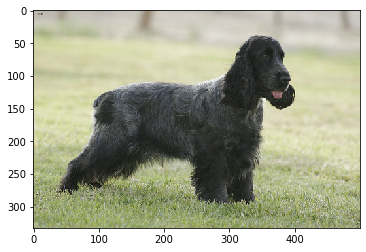

In [45]:
plt.imshow(plt.imread(image_path));

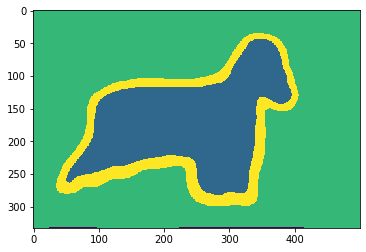

In [46]:
plt.imshow(mask);

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [47]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)